In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict,cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
from scipy.stats import boxcox
import statsmodels.api as sm

In [2]:
import numpy as np 
import pylab 
import scipy.stats as stats

In [3]:
path = os.getcwd()
path = path + '\\' + 'bodyfat.csv'
data = pd.read_csv(path)
data.head()

,Density,BodyFat,BMI,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23.624460,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,23.332048,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,24.666315,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,24.880784,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,25.514854,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [4]:
#BodyFat is the target. 
#We are hoping to use the Model so we don't need to measure density
X_data = data.drop(['BodyFat', 'Density'],axis=1) 


#storing height, weight data incase needed later.  BMI was calculated from these measures in the first project
#this might be redundant since 'data' also contains these values
df_hw = X_data[['Height','Weight']]

#removing columns.  Relying on BMI for their information
X_data = X_data.drop(['Height','Weight'], axis = 1)

Y_data = data['BodyFat']


X_data.head()

,BMI,Age,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,23.624460,23,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,23.332048,22,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,24.666315,22,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,24.880784,26,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,25.514854,24,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [5]:
#This cell determines if our X data is Normal

X_cols = X_data.columns.to_list()

skewlist = []
for col in X_cols:
    ob = normaltest(X_data[col])
    if ob.pvalue < 0.05:
        skewlist.append(col)


print('Skewed variables include:')        
print(skewlist)

print('\nSince obesity is an extreme condition, lets exclude it from the model')

Y_data

Skewed variables include:
['BMI', 'Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm']

Since obesity is an extreme condition, lets exclude it from the model


0      12.3
1       6.1
2      25.3
3      10.4
4      28.7
       ... 
241    11.0
242    33.6
243    29.3
244    26.0
245    31.9
Name: BodyFat, Length: 246, dtype: float64

In [6]:
#removing all obese patients from dataset
X_data = X_data[data['BMI']<30.0]
Y_data = Y_data[data['BMI']<30.0]


In [7]:
#another way to check for normality of the columns
print('Data with Obese people Included')
print(data.skew().sort_values(ascending=False).to_frame().rename(columns={0:'Skew'}))
print('\n\n')
print('Data with Obese people removed')
print(X_data.skew().sort_values(ascending=False).to_frame().rename(columns={0:'Skew'}))

Data with Obese people Included
             Skew
Ankle    2.289860
BMI      1.639816
Hip      1.606410
Weight   1.292419
Abdomen  0.897383
Thigh    0.855690
Chest    0.775233
Neck     0.570604
Knee     0.560494
Biceps   0.287758
Age      0.281010
Wrist    0.270985
BodyFat  0.173623
Height   0.026071
Density -0.090215
Forearm -0.223953



Data with Obese people removed
             Skew
Ankle    2.704831
Age      0.292234
Chest    0.223028
Thigh    0.187763
Knee     0.123080
Biceps   0.092918
BMI      0.075642
Abdomen  0.073981
Wrist    0.057410
Hip      0.035170
Forearm -0.060829
Neck    -0.098120


check for normality of remaining skewed columns


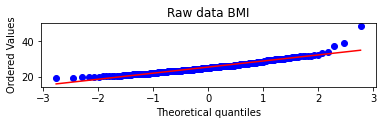

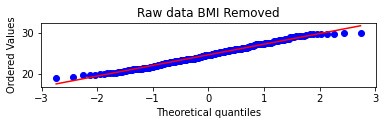

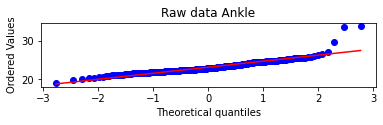

In [8]:
print('check for normality of remaining skewed columns')

plt.subplot(3,1,1)
stats.probplot(data['BMI'], dist="norm", plot=pylab)
pylab.title('Raw data BMI')
pylab.show()

plt.subplot(3,1,2)
stats.probplot(X_data['BMI'], dist="norm", plot=pylab)
pylab.title('Raw data BMI Removed')
pylab.show()

plt.subplot(3,1,3)
stats.probplot(data['Ankle'], dist="norm", plot=pylab)
pylab.title('Raw data Ankle')
pylab.show()

Looks like Ankle Might have an outlier(s)

In [9]:
#This cell determines if our X data is Normal now that we have removed obese paitents

X_cols = X_data.columns.to_list()

skewlist = []
for col in X_cols:
    ob = normaltest(X_data[col])
    if ob.pvalue < 0.05:
        skewlist.append(col)
        print('skewed column: ', col)
        
print('Nonnormal variables include:')        
print(skewlist)


skewed column:  BMI
skewed column:  Ankle
Nonnormal variables include:
['BMI', 'Ankle']


Taking a look at the remaining Skewed columns


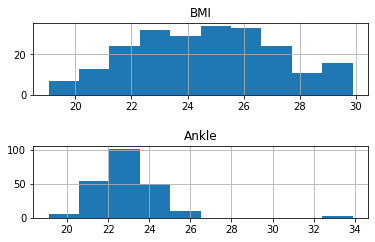

In [10]:
print('Taking a look at the remaining Skewed columns')
figure, axes = plt.subplots(nrows=2, ncols=1)
plt.subplot(2,1,1)
X_data.BMI.hist()
plt.title('BMI')
figure.tight_layout(pad=3.0)
plt.subplot(2,1,2)
plt.title('Ankle')
X_data.Ankle.hist()
plt.show()

It looks like there are remaining outliers in the ankle column.  Lets Explore

In [11]:
#grab the outlying ankle points
Cankles = X_data[X_data['Ankle']>28]
Cankles.head()

,BMI,Age,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
30,23.523539,32,38.7,100.5,88.7,99.8,57.5,38.7,33.9,32.5,27.7,18.4
82,25.767023,67,36.5,98.9,89.7,96.2,54.7,37.8,33.7,32.4,27.7,18.2


In [12]:
#deeper dive into the two 'Ankle' outliers

X_cols = X_data.columns.to_list()

#grabe the mean and stdev of the entire dataset
a = X_data.mean()
b = X_data.std()

df_meta = pd.concat([a,b],axis=1,keys=['mean','stdev'])


#I probably could slice the df without transposing
workingdata = Cankles.transpose()
thirty = workingdata.loc[:,30]
ei2 = workingdata.loc[:,82]

#calculate Z scores for the outlying data points
df_meta['Z_30'] = (thirty - df_meta['mean'])/df_meta['stdev']
df_meta['Z_82'] = (ei2 - df_meta['mean'])/df_meta['stdev']

print('mean is of the whole column from the dataset')
print('stdev is of the whole column from the dataset')
print('Z scores for the rows with the outlying Ankle points')

#we really don't care about the age of the patient for this analysis
df_meta = df_meta.drop(['Age'],axis=0)
df_meta


mean is of the whole column from the dataset
stdev is of the whole column from the dataset
Z scores for the rows with the outlying Ankle points


,mean,stdev,Z_30,Z_82
BMI,24.653439,2.561873,-0.441044,0.434676
Neck,37.686547,2.138619,0.473882,-0.554819
Chest,99.269955,6.601170,0.186337,-0.056044
Abdomen,90.568610,8.417234,-0.221998,-0.103194
Hip,98.601345,5.323774,0.225151,-0.451061
Thigh,58.662780,4.401321,-0.264189,-0.900362
Knee,38.256054,2.090766,0.212337,-0.218128
Ankle,22.975336,1.617659,6.753378,6.629742
Biceps,31.907175,2.785021,0.212862,0.176956
Forearm,28.508072,1.878165,-0.430245,-0.430245


We see that these two people have measurements within 1  standard deviation of the mean for each feature except for Ankle.
This leads me to believe that these data points are true outliers, possibly explained by measurement errors. 

These observations are removed from the analysis



In [13]:
#remove rows containing the outlying Ankle measurements
Y_data=Y_data[X_data['Ankle']<30]
X_data=X_data[X_data['Ankle']<30]

Y_data.index.to_list()==X_data.index.to_list()

True

In [14]:
print('checking the skew of the data without the ankle outliers')

X_data.skew().apply(abs).sort_values(ascending = False)

checking the skew of the data without the ankle outliers


Age        0.287797
Chest      0.223845
Ankle      0.194663
Thigh      0.175550
Knee       0.122536
Neck       0.098850
Biceps     0.097802
BMI        0.075432
Forearm    0.071734
Abdomen    0.069302
Wrist      0.061979
Hip        0.032356
dtype: float64

### Looks like the remaining data has tolerable values for skew.  
## it is interesting that bmi still fails the normality test


In [15]:
#boxcox transformation to normalize BMI column
bc_result = boxcox(X_data.BMI)
boxcox_BMI = bc_result[0]
lam = bc_result[1]
pd.Series(boxcox_BMI).skew()

-0.013824911723240671

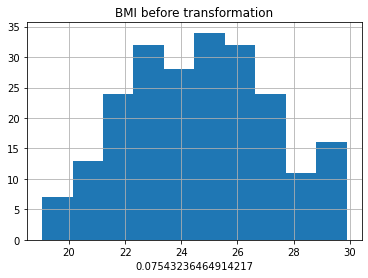

In [16]:
X_data['BMI'].hist()
plt.title('BMI before transformation')
plt.xlabel(X_data['BMI'].skew())
plt.show()

NormaltestResult(statistic=9.592389831077183, pvalue=0.008261121585162443)
Boxcox failed to normalize


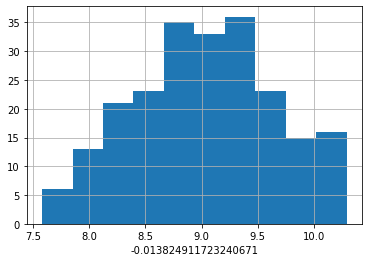

In [17]:
pd.Series(boxcox_BMI).hist()
print(normaltest(boxcox_BMI))
plt.xlabel(pd.Series(boxcox_BMI).skew())
print('Boxcox failed to normalize')



Even with the boccox transformation we are unable to normalize BMI.
Too many overweight people in the dataset.

However, I think removing the overweight people would limit the robustness of the model.

In [18]:

print('do the linear regression with the BMI boxcox transformation')
#copy features and replace BMI with transformed version
print('\n\n')
s = StandardScaler()
df_bx = X_data.copy()
df_bx['BMI']=boxcox_BMI


X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(df_bx, Y_data, test_size=0.3, random_state=72018)


X_train_sb = s.fit_transform(X_train_b)
X_test_sb = s.fit_transform(X_test_b)

print('Standardized Data')
lrbs = LinearRegression()
lrbs.fit(X_train_sb,y_train_b)
y_pred_b = lrbs.predict(X_test_sb)
rb = r2_score(y_test_b, y_pred_b)
print('r2 = ', str(rb))

print('\n\n')
print('Unstandardized Data')
lrb = LinearRegression()
lrb.fit(X_train_b,y_train_b)
y_pred_b = lrb.predict(X_test_b)
r = r2_score(y_test_b, y_pred_b)
print('r2 = ', r)


cross_val_score(lrb,df_bx,Y_data,cv=3)

do the linear regression with the BMI boxcox transformation



Standardized Data
r2 =  0.6604464949660502



Unstandardized Data
r2 =  0.6588604485397731


array([0.716735  , 0.41479759, 0.60762681])

## Initializing Data for remaining analysis
### No Polynomial Features

***
---------------------------------------------------------
***

In [19]:
print('Use this split for other models - no pfs')

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=72018)
X_train_s = s.fit_transform(X_train)
X_test_s = s.fit_transform(X_test)

Use this split for other models - no pfs


In [20]:
print('do the linear regression without the BMI boxcox transformation')
print('\n\n')

print('Unstandardized Data')
print('experimentation purpose only')
lrs = LinearRegression()
lrs.fit(X_train,y_train)
y_pred = lrs.predict(X_test)
sumcoeff = abs(lrs.coef_).sum()
print('r2 = ', r)
r = r2_score(y_test,y_pred)
print('sum of |coef| = ', sumcoeff)
#cross_val_score(lrs,X_data,Y_data,cv=3)


print('\n\n')

print('Standardized Data')

#training the base linear regression model for comparison with regularization
lr = LinearRegression()
lr.fit(X_train_s,y_train)
y_pred = lr.predict(X_test_s)
r = r2_score(y_test,y_pred)
print('r2 = ', r)
sumcoeff = abs(lr.coef_).sum()
print('sum of |coef| = ', sumcoeff)







do the linear regression without the BMI boxcox transformation



Unstandardized Data
experimentation purpose only
r2 =  0.6588604485397731
sum of |coef| =  5.222499359838726



Standardized Data
r2 =  0.660880232678912
sum of |coef| =  14.803979003651751


In [21]:

#the IBM course had the order of r2_scores arguements messed up in some locations
#the code below was for my own sanity!!!

r = r2_score(y_test,y_pred)
print('correct:')
print('test/pred = ', r )
r = r2_score(y_pred,y_test)
print('incorrect:')
print('pred/test = ', r )


correct:
test/pred =  0.660880232678912
incorrect:
pred/test =  0.5925242208749537


In [22]:
#this cell checks if there is a differnce in standardizing xdata before basic OLS
#spoiler, there isn't

lrcvs = LinearRegression()
X_data_s = s.fit_transform(X_data)
predictions = cross_val_predict(lrcvs, X_data_s, Y_data, cv=3)
predictions2 = cross_val_predict(lrcvs, X_data, Y_data, cv=3)
#gives a prediction of each observation when it is in the test category
print('Standardized X_Data: r2 = ', r2_score(Y_data,predictions))
print('Unstandardized X_Data: r2 = ', r2_score(Y_data,predictions2))


Standardized X_Data: r2 =  0.6188712165786994
Unstandardized X_Data: r2 =  0.6188712165787009


## Doesnt seem like boxcox transform of BMI was appropriate
### Standardizing data doesn't make a difference in predictions.  

***
the syntax for r2_score was wrong in some instances in the course and I went on a goose chase
***

In [23]:
x = [1,2,3]
pf = PolynomialFeatures(degree=1)
pf.fit_transform([x])

array([[1., 1., 2., 3.]])

In [24]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV



### Lasso Regression without Polynomial Features

In [25]:
print('using the same test/train/split as LR above')

print('Lasso Regression')

#Use the lassoCV function to come up with alpha

#alphas2 = np.linspace(.0001,.25, 300)
lassoCV = LassoCV(alphas=None,
                  max_iter=5e4,
                  cv=3).fit(X_train_s, y_train)

#lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))
alpha = lassoCV.alpha_
print('alpha = ', alpha)

y_pred_lasso = lassoCV.predict(X_test_s)
print('r2 =', r2_score(y_test,y_pred_lasso))

print(abs(lassoCV.coef_).sum())



using the same test/train/split as LR above
Lasso Regression
alpha =  0.22255635039618565
r2 = 0.661136703399068
10.090301326884902


[0.71561876 0.42651604 0.6318831 ]


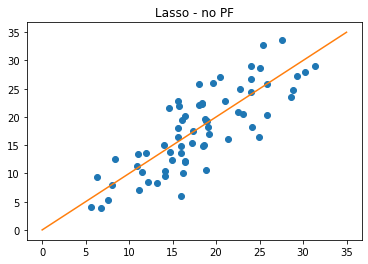

In [26]:
plt.plot(y_pred_lasso,y_test,'o',[0,35],[0,35])
plt.title('Lasso - no PF')
print(cross_val_score(lassoCV, X_data, Y_data, cv=3))

### Ridge Regression without Polynomial Features

In [27]:
print('Ridge Regression')

alphas2 = np.linspace(0,10, 300)

ridgeCV = RidgeCV(alphas=alphas2,
                  cv=3).fit(X_train_s, y_train)

#lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))
alpha = ridgeCV.alpha_

print('alpha = ', alpha)

y_pred_ridge = ridgeCV.predict(X_test_s)
print('r2 =', r2_score(y_test,y_pred_ridge))
coef = abs(ridgeCV.coef_).sum()

print
print('sum of |coef| = ', coef)

print('Cross Val R2 = ')
print(cross_val_score(ridgeCV, s.fit_transform(X_data), Y_data, cv=3).mean())

Ridge Regression
alpha =  9.665551839464882
r2 = 0.6368811741565552
sum of |coef| =  12.4184986777955
Cross Val R2 = 
0.5790917970379036


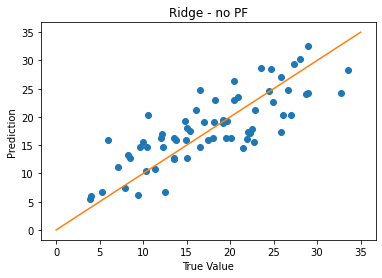

In [28]:
plt.plot(y_test,y_pred_ridge,'o',[0,35],[0,35])
plt.title('Ridge - no PF')
plt.xlabel('True Value')
plt.ylabel('Prediction')
plt.show()

### Comparing the parameters of the standardized models

In [29]:
print('Looking at the Coefs of the models trained on standardized X_data')
print('\n with standardized data')

cols = X_data.columns.to_list()
lrc = lr.coef_
lasc = lassoCV.coef_
ridgec = ridgeCV.coef_
dict1 = {'LR':lrc,'Ridge': ridgec, 'Lasso':lasc}
noPFdf = pd.DataFrame(dict1,index=cols)

#pd.DataFrame(noPFdf.abs)

noPFdf.abs().sort_values(by='Lasso',ascending=False)

Looking at the Coefs of the models trained on standardized X_data

 with standardized data


,LR,Ridge,Lasso
Abdomen,6.615432,4.780401,5.901866
Wrist,2.005245,1.723832,1.683965
BMI,2.105915,1.979395,1.183187
Age,0.930067,1.172316,0.754612
Neck,1.292544,0.939983,0.400140
Ankle,0.217619,0.414232,0.166531
Chest,0.259646,0.603475,0.000000
Hip,0.763956,0.147820,0.000000
Thigh,0.141944,0.325256,0.000000
Knee,0.008196,0.086471,0.000000


### Adding PFs
##Degree 2

In [30]:
#2nd degree polynomial features

pf = PolynomialFeatures(degree=2, include_bias=False)
X_poly2 = pf.fit_transform(X_data)

X_train, X_test, y_train, y_test = train_test_split(X_poly2, Y_data, test_size=0.3, 
                                                    random_state=72018)
X_train_s2 = s.fit_transform(X_train)
X_test_s2 = s.fit_transform(X_test)

Linear Regression - 2nd degree
r2 = -0.10826648450068266


Text(0.5, 1.0, 'Linear - 2 deg PF')

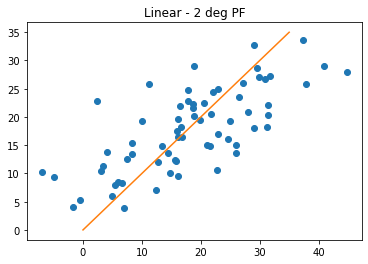

In [31]:
print('Linear Regression - 2nd degree')

lr2 = LinearRegression()
lr2.fit(X_train_s2,y_train)
y_pred = lr2.predict(X_test_s2)

r = r2_score(y_test,y_pred)

print('r2 =', r)

plt.plot(y_pred,y_test,'o',[0,35],[0,35])
plt.title('Linear - 2 deg PF')

Ridge Regression - 2nd degree
alpha =  56.785714285714285
r2 = 0.6328601107530378
15.798597744936808


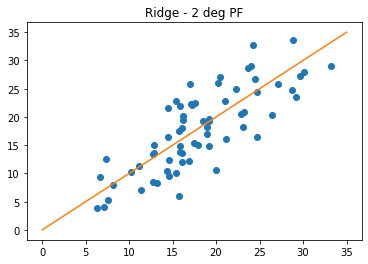

In [32]:
print('Ridge Regression - 2nd degree')



alphas2 = np.linspace(55,60, 15)

ridgeCV2 = RidgeCV(alphas=alphas2,
                  cv=3).fit(X_train_s2, y_train)

#lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))
alpha = ridgeCV2.alpha_

print('alpha = ', alpha)

y_pred_ridge = ridgeCV2.predict(X_test_s2)
print('r2 =', r2_score(y_test,y_pred_ridge))

plt.plot(y_pred_ridge,y_test,'o',[0,35],[0,35])
plt.title('Ridge - 2 deg PF')
#print('Cross Val R2 = ')
#print(cross_val_score(ridgeCV, X_data, Y_data, cv=3))

print(abs(ridgeCV2.coef_).sum())


In [33]:
print('using the same 2nd order pf and test/train/split as Ridge above')


print('Lasso Regression - 2nd degree')

#Use the lassoCV function to come up with alpha


lassoCV2 = LassoCV(alphas=np.linspace(.20,.3,8),
                  max_iter=5e4,
                  cv=3).fit(X_train_s2, y_train)

#lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))
alpha = lassoCV2.alpha_
print('alpha = ', alpha)

y_pred_lasso = lassoCV2.predict(X_test_s2)
print('r2 =', r2_score(y_test,y_pred_lasso))

print(abs(lassoCV2.coef_).sum())



using the same 2nd order pf and test/train/split as Ridge above
Lasso Regression - 2nd degree
alpha =  0.2571428571428571
r2 = 0.6597861145312927
9.677783160933009


### Degree 4

In [34]:
pf4 = PolynomialFeatures(degree=4, include_bias=False)
X_polyg = pf4.fit_transform(X_data)

X_train, X_test, y_train, y_test = train_test_split(X_polyg, Y_data, test_size=0.3, 
                                                    random_state=72018)

X_train_sg = s.fit_transform(X_train)
X_test_sg = s.fit_transform(X_test)

Ridge Regression
alpha =  741.4141414141415
r2 = 0.6114844659842716
20.903859194896306


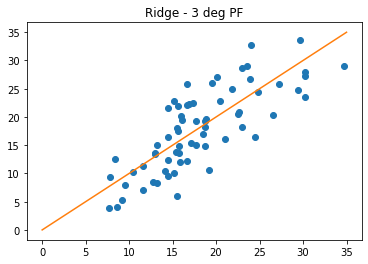

In [35]:

print('Ridge Regression')
a = 700
b = 800
alphas2 = np.linspace(a,b, 100)

ridgeCV = RidgeCV(alphas=alphas2,
                  cv=3).fit(X_train_sg, y_train)

#lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))
alpha = ridgeCV.alpha_

print('alpha = ', alpha)

y_pred_ridge = ridgeCV.predict(X_test_sg)
print('r2 =', r2_score(y_test,y_pred_ridge))

plt.plot(y_pred_ridge,y_test,'o',[0,35],[0,35])
plt.title('Ridge - 3 deg PF')
#print('Cross Val R2 = ')
#print(cross_val_score(ridgeCV, X_data, Y_data, cv=3))7


print(abs(ridgeCV.coef_).sum())


In [36]:
print('using the same gnd order pf and test/train/split as Ridge above')



print('Lasso Regression')

#Use the lassoCV function to come up with alpha


lassoCV = LassoCV(alphas=np.linspace(.2,.3,8),
                  max_iter=5e4,
                  cv=3).fit(X_train_sg, y_train)

#lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))
alpha = lassoCV.alpha_
print('alpha = ', alpha)

y_pred_lasso = lassoCV.predict(X_test_sg)
print('r2 =', r2_score(y_test,y_pred_lasso))

print(abs(lassoCV.coef_).sum())



using the same gnd order pf and test/train/split as Ridge above
Lasso Regression
alpha =  0.2857142857142857
r2 = 0.659834658473028
9.336873110015224


### GridSearch Way
## Not a fan of this because it finds the parameters and hyperparameters on the whole dataset

## Ridge

In [37]:
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1,2,3],
    'ridge_regression__alpha': np.geomspace(2.5, 15, 30)
}

r_grid = GridSearchCV(estimator, params, cv=3)

In [38]:
r_grid.fit(X_data, Y_data)
print(r_grid.best_score_, r_grid.best_params_)
gp = r_grid.predict(X_data)
r2_score(Y_data,gp)

0.5832883097851893 {'polynomial_features__degree': 1, 'ridge_regression__alpha': 3.0091124245911667}


0.6880295802967116

## Lasso

In [39]:
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("Lasso_regression", Lasso(max_iter=5e4))])

params = {
    'polynomial_features__degree': [1,2,3],
    'Lasso_regression__alpha': np.geomspace(.001, 1, 10)
}

a_grid = GridSearchCV(estimator, params, cv=3)


In [40]:
a_grid.fit(X_data, Y_data)
print(a_grid.best_score_, a_grid.best_params_)
gp = a_grid.predict(X_data)
r2_score(Y_data,gp)

C:\Users\mmatr\anaconda3\envs\dsfs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.707691635814838, tolerance: 0.6920184217687075
  positive)
C:\Users\mmatr\anaconda3\envs\dsfs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.334945852163774, tolerance: 0.9843781768707482
  positive)
C:\Users\mmatr\anaconda3\envs\dsfs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6421520732211796, tolerance: 0.7920193175675676
  positive)
C:\Users\mmatr\anaconda3\envs\dsfs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want t

0.6199245257636469 {'Lasso_regression__alpha': 0.21544346900318823, 'polynomial_features__degree': 2}


0.6992715996993318